###### Pymagicc Demo

This small demo of Pymagicc (see https://github.com/openscm/pymagicc)
is built using a [Jupyter Notebook](http://jupyter.org/) and [Appmode](https://github.com/oschuett/appmode). Thanks to the [Binder](https://mybinder.org/) project it can be found online at:

https://mybinder.org/v2/gh/openscm/pymagicc/master?urlpath=apps%2Fnotebooks%2FDemo.ipynb

It shows output from Pymagicc for the four [Representative Concentration Pathways (RCPs)](http://tntcat.iiasa.ac.at:8787/RcpDb/dsd?Action=htmlpage&page=welcome). One of the many model parameters, the climate sensitivity, can be adjusted. To see how the demo is made or change it, click on "Edit App" above.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymagicc

from ipywidgets import widgets
from IPython.display import Javascript

from functools import lru_cache

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
@lru_cache(maxsize=32)
def run_pymagicc(scenario, core_climatesensitivity=3):
    return pymagicc.run(
        getattr(pymagicc, scenario.lower()),
        core_climatesensitivity=core_climatesensitivity,
    )

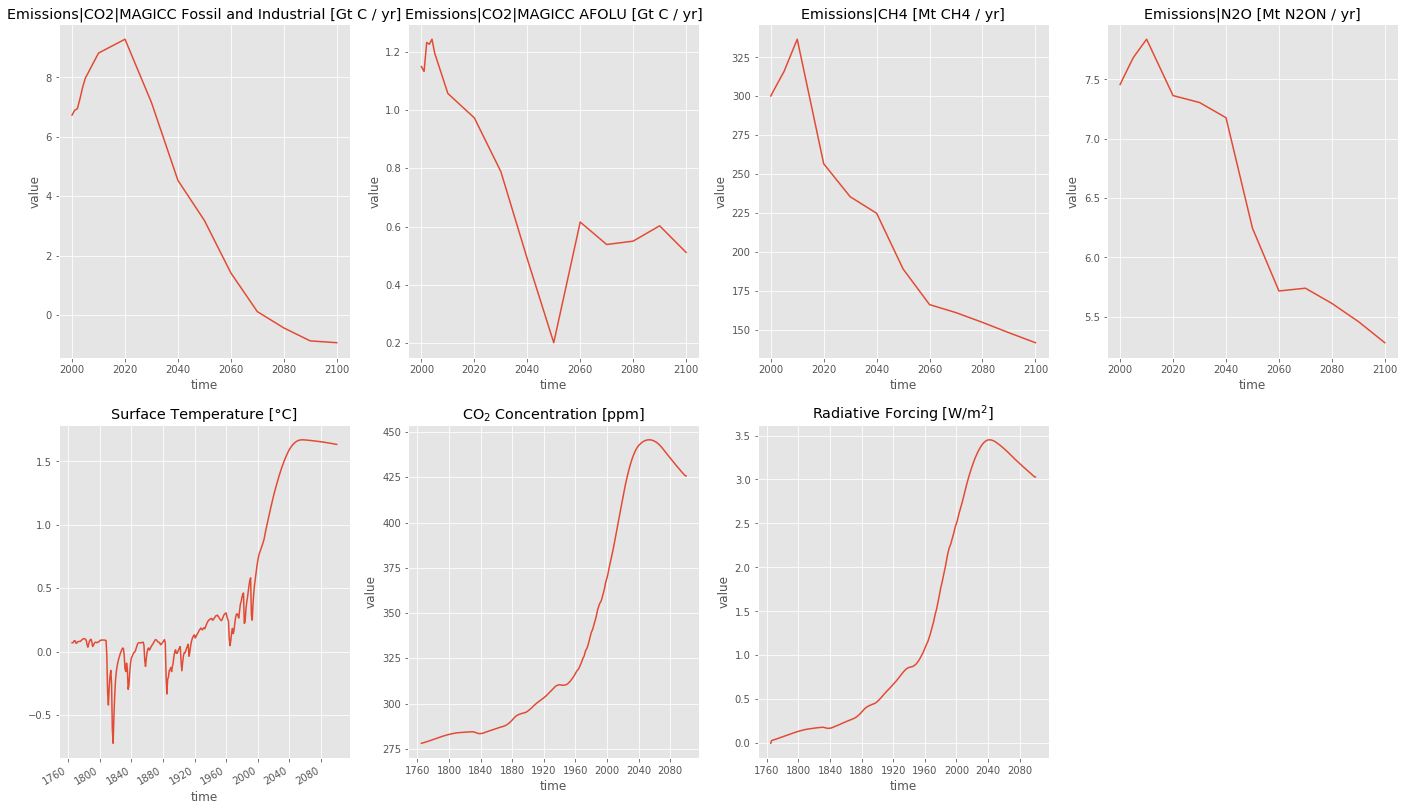

Output()

In [4]:
# NBVAL_IGNORE_OUTPUT
# Reference period
start = 1850
end = 1900

widget_scenario = widgets.Dropdown(
    title="Emissions Scenario",
    value="RCP26",
    options=["RCP26", "RCP45", "RCP60", "RCP85"],
)

widget_status = widgets.HTML()

gases = pymagicc.rcp26["variable"].tolist()

widget_gas_1 = widgets.Dropdown(
    title="Emissions from",
    value="Emissions|CO2|MAGICC Fossil and Industrial",
    options=gases,
)
widget_gas_2 = widgets.Dropdown(
    title="Emissions from", value="Emissions|CO2|MAGICC AFOLU", options=gases
)
widget_gas_3 = widgets.Dropdown(
    title="Emissions from", value="Emissions|CH4", options=gases
)
widget_gas_4 = widgets.Dropdown(
    title="Emissions from", value="Emissions|N2O", options=gases
)

style = {"description_width": "initial"}
widget_core_climatesensitivity = widgets.FloatSlider(
    value=3,
    min=1.5,
    max=4.5,
    step=0.1,
    continuous_update=False,
    description="Climate Sensitivity",
    style=style,
)

scen = pymagicc.rcp26
data = scen.filter(
    region="World",
    variable="Emissions|CO2|MAGICC Fossil and Industrial",
    year=range(1, 2101),
)

widget_output = widgets.Output()

ui = widgets.VBox(
    [
        widgets.HBox([widget_scenario, widget_status]),
        widgets.HBox([widget_gas_1, widget_gas_2, widget_gas_3, widget_gas_4]),
        widget_core_climatesensitivity,
        widget_output,
    ]
)


def update(scenario, gas_1, gas_2, gas_3, gas_4, core_climatesensitivity):
    widget_status.value = "<em>Processing</em> …"
    scen = getattr(pymagicc, scenario.lower())
    data = scen.filter(region="World", year=range(1, 2101),)

    results = run_pymagicc(
        scenario, core_climatesensitivity=core_climatesensitivity
    )

    fig, axes = plt.subplots(2, 4, figsize=(24, 15))
    for i, gas in enumerate([gas_1, gas_2, gas_3, gas_4]):
        gas_data = data.filter(variable=gas)
        unit = gas_data["unit"].iloc[0]
        gas_data.line_plot(x="time", ax=axes[0, i], legend=False)
        axes[0, i].set_title("{} [{}]".format(gas, unit))

    temp = results.filter(
        variable="Surface Temperature", region="World",
    ).relative_to_ref_period_mean(year=range(start, end + 1)).timeseries()
    temp.T.plot(ax=axes[1, 0], legend=False)
    axes[1, 0].set_title("Surface Temperature [°C]")

    results.filter(
        variable="Atmospheric Concentrations|CO2", region="World",
    ).line_plot(x="time", ax=axes[1, 1], legend=False)
    axes[1, 1].set_title("CO$_2$ Concentration [ppm]")

    results.filter(
        variable="Radiative Forcing|Greenhouse Gases", region="World",
    ).line_plot(x="time", ax=axes[1, 2], legend=False)
    axes[1, 2].set_title("Radiative Forcing [W/m$^2$]")

    axes[1, 3].remove()
    widget_status.value = ""


out = widgets.interactive_output(
    update,
    {
        "scenario": widget_scenario,
        "gas_1": widget_gas_1,
        "gas_2": widget_gas_2,
        "gas_3": widget_gas_3,
        "gas_4": widget_gas_4,
        "core_climatesensitivity": widget_core_climatesensitivity,
    },
)

display(ui, out)

Surface temperature is relative to the pre-industrial 1850-1900 period.